In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# use ggplot style
plt.style.use('ggplot')


def load_array(filename, task):
    datapoint = np.load(filename)
    if task == 'task 1':
        initial_state = datapoint['initial_state']
        terminal_state = datapoint['terminal_state']
        return initial_state, terminal_state
    elif task == 'task 2' or task == 'task 3':
        whole_trajectory = datapoint['trajectory']
        # change shape: (num_bodies, attributes, time) ->  num_bodies, time, attributes
        whole_trajectory = np.swapaxes(whole_trajectory, 1, 2)
        initial_state = whole_trajectory[:, 0]
        target = whole_trajectory[:, 1:, 1:]  # drop the first timepoint (second dim) and mass (last dim) for the prediction task
        return initial_state, target
    else:
        raise NotImplementedError("'task' argument should be 'task 1', 'task 2' or 'task 3'!")

In [2]:
#### Create adjacency matrix

# Define distance metrics
def euclidean_distance(x, y):
    return torch.sqrt(torch.sum((x - y)**2))

def inverse_distance(x, y):
    return 1 / euclidean_distance(x, y)

# Create adjacency matrix function
def create_adjacency_matrix(data, distance_metric):
    n = data.shape[0]
    adjacency_matrix = torch.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:  # we don't calculate the distance of the object to itself
                # we extract the position [x, y] for both objects i and j
                position_i = data[i, 1:3]
                position_j = data[j, 1:3]
                adjacency_matrix[i, j] = distance_metric(position_i, position_j)
    return adjacency_matrix

# Validate input
def validate_input(X, adjacency_matrix):
    # X should be a 2D tensor
    assert X.dim() == 2, f"X must be 2D, but got shape {X.shape}"

    # The number of nodes should be the same in X and the adjacency matrix
    assert X.shape[0] == adjacency_matrix.shape[0] == adjacency_matrix.shape[1], \
        f"Mismatch in number of nodes: got {X.shape[0]} nodes in X, but {adjacency_matrix.shape[0]} nodes in adjacency matrix"

    # The adjacency matrix should be square
    assert adjacency_matrix.shape[0] == adjacency_matrix.shape[1], \
        f"Adjacency matrix must be square, but got shape {adjacency_matrix.shape}"

    print("All checks passed.")


In [3]:
# Load and examine sample data
"""
This cell gives an example of loading a datapoint with numpy for task 1.

The arrays returned by the function are structures as follows:
initial_state(X): shape (n_bodies, [mass, x, y, v_x, v_y])
terminal_state(y): shape (n_bodies, [x, y])

"""


X, y= load_array('data/task 1/train/trajectory_0.npz', task='task 1')
X = torch.tensor(X, dtype=torch.float32)


In [4]:
# Testing adjacency matrix
adjacency_matrix = create_adjacency_matrix(X, inverse_distance)

In [5]:
# Test network
from torch_geometric.nn import GraphConv
from torch_geometric.data import Data

class SimpleGNN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(SimpleGNN, self).__init__()
        self.conv1 = GraphConv(num_features, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # 1st Graph Convolution layer
        x = self.conv1(x, edge_index)
        x = torch.relu(x)

        # 2nd Graph Convolution layer
        x = self.conv2(x, edge_index)

        return x


# Convert adjacency matrix to edge_index
# WARNING! This will 'Delete' the distances between the nodes
edge_index = adjacency_matrix.nonzero().t()

# Create a Data object
data = Data(x=X, edge_index=edge_index)

# Create an instance of our GNN
model = SimpleGNN(num_features=5, hidden_channels=32, num_classes=2)

# Pass the graph through the model
out = model(data)

print(out.shape)
edge_index[:, 4]

torch.Size([8, 2])


tensor([0, 5])

In [6]:
# Model Zoo
from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_channels*2)
        self.conv2 = SAGEConv(hidden_channels*2, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, int(hidden_channels/2))

        self.fc = torch.nn.Linear(int(hidden_channels/2), num_classes)
        self.dropout = torch.nn.Dropout(p=0.3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # 1st GraphSAGE layer
        x = self.conv1(x, edge_index)
        x = torch.relu(x)

        # 2nd GraphSAGE layer
        x = self.conv2(x, edge_index)
        x = torch.relu(x)

        # 3rd GraphSAGE layer
        x = self.conv3(x, edge_index)
        x = torch.relu(x)

        # Dropout
        x = self.dropout(x)

        # Linear layer
        x = self.fc(x)

        return x

class MinGraphSAGE(torch.nn.Module):
    # FINAL MODEL!
    def __init__(self, num_features, hidden_channels, num_classes):
        super(MinGraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_channels*2)
        self.conv2 = SAGEConv(hidden_channels*2, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, num_classes)

        self.dropout = torch.nn.Dropout(p=0.3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # 1st GraphSAGE layer
        x = self.conv1(x, edge_index)
        x = torch.relu(x)

        # Droput
        x = self.dropout(x)

        # 2nd GraphSAGE layer
        x = self.conv2(x, edge_index)
        x = torch.relu(x)

        # 3rd GraphSAGE layer
        x = self.conv3(x, edge_index)

        return x

from torch_geometric.nn import BatchNorm

class ImprovedGraphSAGE(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(ImprovedGraphSAGE, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_channels*2)
        self.batch_norm1 = BatchNorm(hidden_channels*2)
        self.conv2 = SAGEConv(hidden_channels*2, hidden_channels)
        self.batch_norm2 = BatchNorm(hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # 1st GraphSAGE layer
        x = self.conv1(x, edge_index)
        x = self.batch_norm1(x)
        x = torch.relu(x)

        # 2nd GraphSAGE layer
        x = self.conv2(x, edge_index)
        x = self.batch_norm2(x)
        x = torch.relu(x)

        # 3rd GraphSAGE layer
        x = self.conv3(x, edge_index)

        return x



In [85]:
# DataLoader

from torch_geometric.data import Dataset, Data, DataLoader

class MyDataset(Dataset):
    def __init__(self, root, filenames, transform=None, pre_transform=None):
        self.filenames = filenames
        super(MyDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return self.filenames

    def len(self):
        return len(self.filenames)

    def get(self, idx):
        X, y = load_array(self.filenames[idx], task='task 1')
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        adjacency_matrix = create_adjacency_matrix(X, inverse_distance)
        edge_index = adjacency_matrix.nonzero().t()

        data = Data(x=X, y=y, edge_index=edge_index)

        return data

filenames = [f'data/task 1/train/trajectory_{i}.npz' for i in range(900)]

split_point = 720 # take 20% of the data for validation

# Create two subsets for train/validation split from the filenames list
train_filenames = filenames[:split_point]
val_filenames = filenames[split_point:]

train_dataset = MyDataset(root='data/task 1/train', filenames=train_filenames)
train_dataloader = DataLoader(train_dataset, batch_size=32)

# Create validation dataset from val_filenames
val_dataset = MyDataset(root='data/task 1/train', filenames=val_filenames)
val_dataloader = DataLoader(val_dataset, batch_size=32)

# Prepare for validation data set

test_filenames = [f'data/task 1/test/trajectory_{i}.npz' for i in range(901, 1000)]
test_dataset = MyDataset(root='data/task 1/test', filenames=test_filenames)
test_dataloader = DataLoader(test_dataset, batch_size=32)

c:\Users\dagos\miniconda3\envs\mlcourse\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 1, Training Loss: 7.409277439117432, Val Loss: 7.060731050703261
Epoch: 2, Training Loss: 6.401893615722656, Val Loss: 6.193772877587213
Epoch: 3, Training Loss: 6.762507438659668, Val Loss: 5.879937553405762
Epoch: 4, Training Loss: 6.360713958740234, Val Loss: 5.727308368682861
Epoch: 5, Training Loss: 5.763978958129883, Val Loss: 5.688933478461371
Epoch: 6, Training Loss: 5.996958255767822, Val Loss: 5.4995663748847115
Epoch: 7, Training Loss: 5.946693420410156, Val Loss: 5.413662624359131
Epoch: 8, Training Loss: 5.657482147216797, Val Loss: 5.408698474036322
Epoch: 9, Training Loss: 5.491055488586426, Val Loss: 5.3470978418986
Epoch: 10, Training Loss: 5.605968952178955, Val Loss: 5.306020662519667
Epoch: 11, Training Loss: 5.40663480758667, Val Loss: 5.2149519072638615
Epoch: 12, Training Loss: 5.481427192687988, Val Loss: 5.2348069508870445
Epoch: 13, Training Loss: 5.50578498840332, Val Loss: 5.249486117892795
Epoch: 14, Training Loss: 5.654817581176758, Val Loss: 5.1768

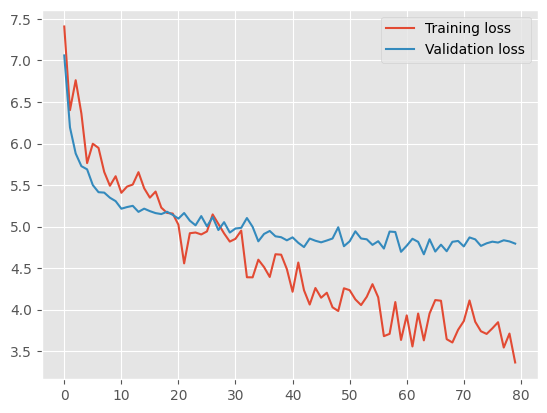

In [9]:
device = "mps"
device = "cpu"
model = MinGraphSAGE(num_features=5, hidden_channels=64, num_classes=2).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
criterion = torch.nn.MSELoss()  # we use Mean Squared Error loss for regression tasks

# Store losses
train_losses = []
val_losses = []

epochs = 80

for epoch in range(epochs):  
    # Training
    model.train()
    for batch in train_dataloader:
        batch = batch.to(device)  # move batch to the device
        optimizer.zero_grad()  # set gradients to zero
        out = model(batch)  # forward pass
        loss = criterion(out, batch.y)  # compute loss
        loss.backward()  # backward pass (compute gradients)
        optimizer.step()  # update model parameters
    train_losses.append(loss.item())

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            out = model(batch)
            val_loss += criterion(out, batch.y).item() * batch.num_graphs
        
    val_loss /= len(val_dataset)  # compute average validation loss
    val_losses.append(val_loss)

    print(f'Epoch: {epoch+1}, Training Loss: {loss.item()}, Val Loss: {val_loss}')


# Plot losses
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

In [10]:
# Calculate MSE loss on test set
model.eval()
test_loss = 0
with torch.no_grad():
    for batch in test_dataloader:
        batch = batch.to(device)
        out = model(batch)
        test_loss += criterion(out, batch.y).item() * batch.num_graphs
    
test_loss /= len(test_dataset)  # compute average validation loss
print(f'Test Loss for task 1: {test_loss}')

Test Loss for task 1: 3.4682799686085093


In [11]:
# Calculate static and linear baselines (formula on ANS)
def static_baseline(X):
    return X[:, 1:3]  # initial x,y coordinates

def linear_baseline(X):
    return X[:, 1:3] + X[:, 3:5] * 5  # initial x,y coordinates plus velocity times time

def compute_baseline_loss(baseline_fn, dataloader):
    total_loss = 0
    criterion = torch.nn.MSELoss()  # we use Mean Squared Error loss for regression tasks

    for batch in dataloader:
        batch = batch.to(device)
        predictions = baseline_fn(batch.x).to(device)
        total_loss += criterion(predictions, batch.y).item() * batch.num_graphs

    return total_loss / len(dataloader.dataset)

train_loss_static = compute_baseline_loss(static_baseline, train_dataloader)
train_loss_linear = compute_baseline_loss(linear_baseline, train_dataloader)

val_loss_static = compute_baseline_loss(static_baseline, val_dataloader)
val_loss_linear = compute_baseline_loss(linear_baseline, val_dataloader)

test_loss_static = compute_baseline_loss(static_baseline, test_dataloader)
test_loss_linear = compute_baseline_loss(linear_baseline, test_dataloader)

 # now print out with filler spaces to make it easier to read
print(f'Training Loss   - Static Baseline: {train_loss_static:0.4f}, Linear Baseline: {train_loss_linear:0.4f}')
print(f'Validation Loss - Static Baseline: {val_loss_static:0.4f}, Linear Baseline: {val_loss_linear:0.4f}')
print(f'Test Loss - Static Baseline: {test_loss_static:0.4f}, Linear Baseline: {test_loss_linear:0.4f}')


Training Loss   - Static Baseline: 14.0342, Linear Baseline: 21.9515
Validation Loss - Static Baseline: 13.5344, Linear Baseline: 23.0688
Test Loss - Static Baseline: 11.4824, Linear Baseline: 20.2710


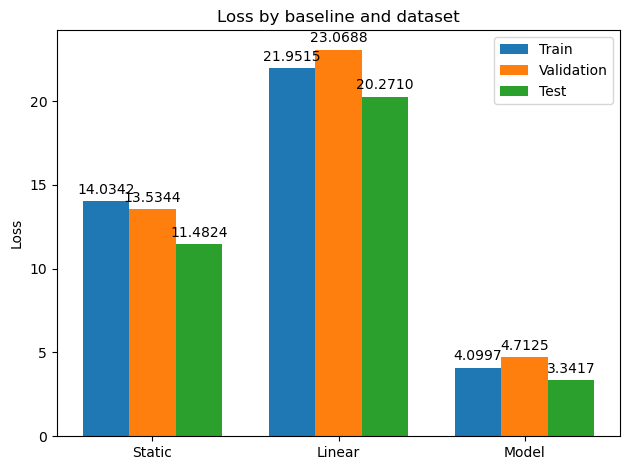

In [58]:
# Create barplot with static and linear baseline losses for train-test-val 3 separate bars

import matplotlib.pyplot as plt
import numpy as np


train_losses = [train_loss_static, train_loss_linear, loss.item()]
val_losses = [val_loss_static, val_loss_linear, val_loss]
test_losses = [test_loss_static, test_loss_linear, test_loss]

x = np.arange(len(train_losses))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_losses, width, label='Train')
rects2 = ax.bar(x, val_losses, width, label='Validation')
rects3 = ax.bar(x + width, test_losses, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Loss')
ax.set_title('Loss by baseline and dataset')
ax.set_xticks(x)
ax.set_xticklabels(['Static', 'Linear', "Model"])
ax.legend()

# Add numbers on top of bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:  # for each bar
        height = rect.get_height()  # get height of bar
        ax.annotate(f'{height:0.4f}',  # annotate with height
                    xy=(rect.get_x() + rect.get_width() / 2, height),  # put label in the middle of the bar
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Do the autolabel
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

# Experiments

Take the 10 trajectories with highest and lowest loss to analyse.

/home/gabrielziegler/PyEnv/DeepLearning/lib/python3.8/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


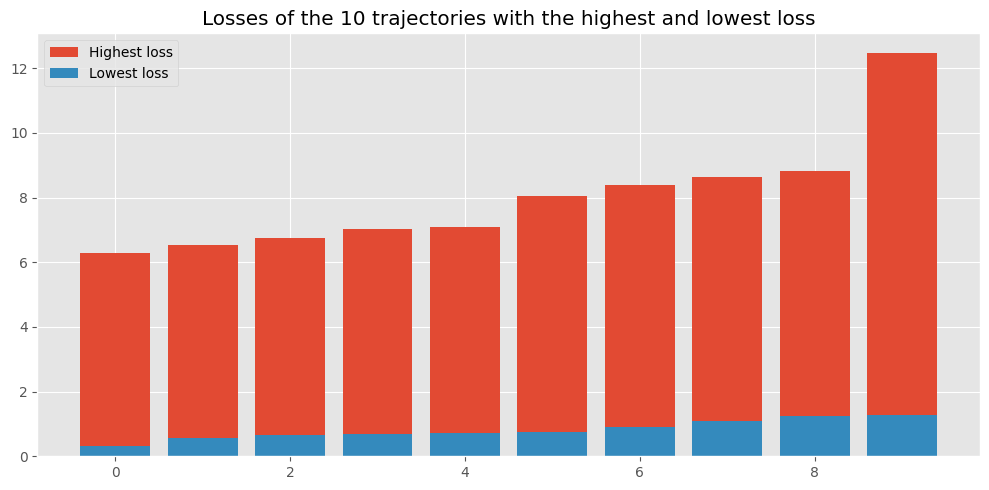

In [12]:
# 6a experiment: grab 10 trajectories from the experiment set that were correctly predicted and 10 that were incorrectly predicted to analyse them

experiment_dataloader = DataLoader(test_dataset, batch_size=1)

experiment_losses = []
experiment_predictions = []
experiment_labels = []

model.eval()
with torch.no_grad():
    for batch in experiment_dataloader:
        batch = batch.cpu()
        out = model.cpu()(batch)
        loss = criterion(out, batch.y)
        experiment_losses.append(loss.item())
        experiment_predictions.append(out)
        experiment_labels.append(batch.y)

# Get the indices of the 10 trajectories with the highest loss
highest_loss_indices = np.argsort(experiment_losses)[-10:]

# Get the indices of the 10 trajectories with the lowest loss
lowest_loss_indices = np.argsort(experiment_losses)[:10]

# np.array(experiment_losses)[highest_loss_indices]
# plot 10 bars with the losses of the 10 trajectories with the highest loss and the 10 trajectories with the lowest loss with the same y-axis
plt.figure(figsize=(10, 5))
plt.bar(np.arange(10), np.array(experiment_losses)[highest_loss_indices], label='Highest loss')
plt.bar(np.arange(10), np.array(experiment_losses)[lowest_loss_indices], label='Lowest loss')
plt.title('Losses of the 10 trajectories with the highest and lowest loss')
plt.tight_layout()
plt.legend()
plt.show()


In [13]:
def plot_trajectories(indices, title=""):
    trajectories = test_dataset[indices]

    # fig, axes = plt.subplots(1, len(trajectories), sharex=True, sharey=True)
    fig, axes = plt.subplots(1, len(trajectories), sharex=True, sharey=True, figsize=(20, 5))

    # set axes limits
    axes[0].set_xlim(-10, 10)
    axes[0].set_ylim(-10, 10)

    # iterate over projections
    for i in range(len(trajectories)):
        # Get the initial position
        initial_position_x = trajectories.x[i][1]
        initial_position_y = trajectories.x[i][2]

        # Get the final position
        final_position_x = trajectories.y[i][0]
        final_position_y = trajectories.y[i][1]

        axes[i].scatter(initial_position_x, initial_position_y, label='Initial position', marker='o', s=100)
        axes[i].scatter(final_position_x, final_position_y, label='Final position', marker='x', s=100)

        # Get the predicted position
        predicted_position_x = experiment_predictions[indices][i][0]
        predicted_position_y = experiment_predictions[indices][i][1]

        axes[i].scatter(predicted_position_x, predicted_position_y, label='Predicted position', marker='p', s=100)

        # Draw dashed line from initial position to predicted position
        axes[i].plot([initial_position_x, predicted_position_x], [initial_position_y, predicted_position_y], 'r--')

        # Get the label
        label = experiment_labels[indices]

        # Draw dashed line from initial position to label
        axes[i].plot([initial_position_x, label[i][0]], [initial_position_y, label[i][1]], 'b--')

        axes[i].legend()
    
    # set title
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


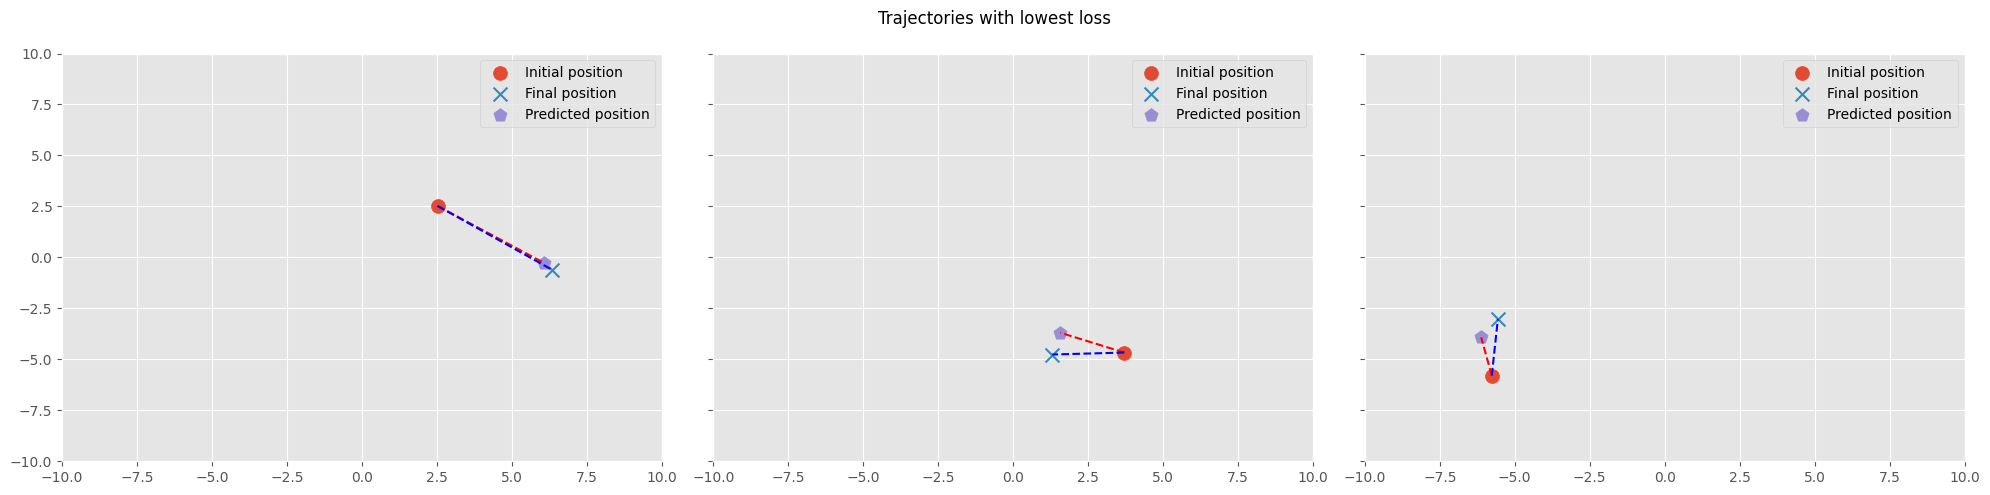

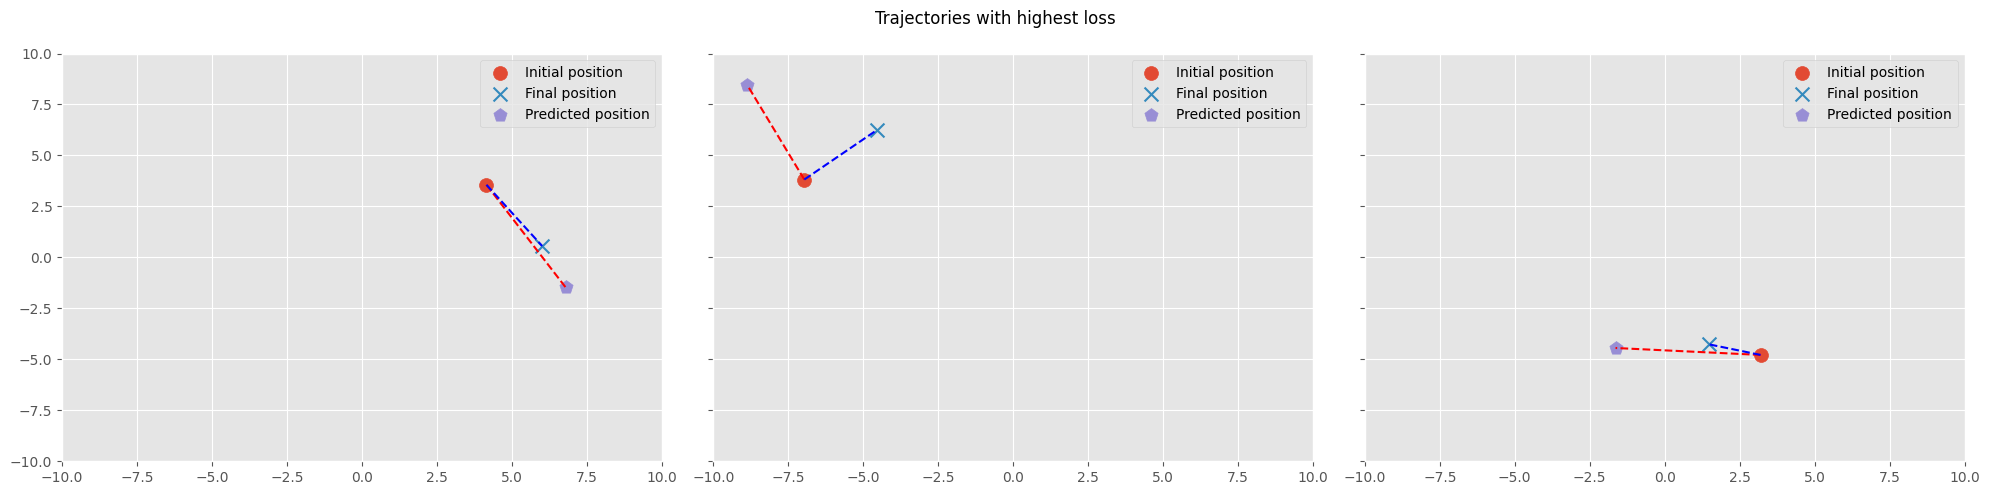

In [14]:
plot_trajectories(lowest_loss_indices[0], title="Trajectories with lowest loss")
plot_trajectories(highest_loss_indices[-1], title="Trajectories with highest loss")

---
# Task 2


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.data import Dataset, Data, DataLoader
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GraphConv
from torch_geometric.data import Data

In [4]:
# Check datashape
X, y= load_array('data/task 2_3/train/trajectory_0.npz', task='task 2')
X.shape, y.shape

((8, 5), (8, 49, 4))

In [5]:
# Model Zoo for TASK 2

from torch_geometric.nn import SAGEConv
import torch.nn as nn

class GraphLSTM(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, num_time_steps):
        super(GraphLSTM, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_channels*2)
        self.conv2 = SAGEConv(hidden_channels*2, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.lstm = nn.LSTM(input_size=hidden_channels, hidden_size=hidden_channels*2, batch_first=True)

        # add a sequential 2 fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(hidden_channels*2, num_classes)
        )
        self.num_time_steps = num_time_steps

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # 1st GraphSAGE layer
        x = self.conv1(x, edge_index)
        x = torch.relu(x)

        # 2nd GraphSAGE layer
        x = self.conv2(x, edge_index)
        x = torch.relu(x)

        # 3rd GraphSAGE layer
        x = self.conv3(x, edge_index)
        x = torch.relu(x)
 
        # mu, log_var 

        # LSTM layer
        # Repeat x along a new temporal dimension to create a sequence, with the repeated
        # x as the input at each time step. This is necessary because the LSTM expects
        # input of the form (batch_size, sequence_length, input_size).
        x = x.unsqueeze(1).repeat(1, self.num_time_steps, 1)

        # Pass the sequence of node states through the LSTM.
        # Note that we discard the LSTM's hidden state output, as we are only
        # interested in its output sequences for this application.
        x, _ = self.lstm(x)

        #  Pass it through the fully connected layers
        x = self.fc(x)

        return x

class GraphLSTM2(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, num_time_steps):
        super(GraphLSTM2, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_channels*2)
        self.conv2 = SAGEConv(hidden_channels*2, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.lstm1 = nn.LSTM(input_size=hidden_channels, hidden_size=hidden_channels*2, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=hidden_channels*2, hidden_size=hidden_channels*2, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_channels*2, num_classes)
        )
        self.num_time_steps = num_time_steps

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)
        x = torch.relu(x)
        x = x.unsqueeze(1).repeat(1, self.num_time_steps, 1)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.fc(x)
        return x

class GraphGRU(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, num_time_steps):
        super(GraphGRU, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_channels*2)
        self.conv2 = SAGEConv(hidden_channels*2, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels)
        self.gru = nn.GRU(input_size=hidden_channels, hidden_size=hidden_channels*2, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_channels*2, num_classes)
        )
        self.num_time_steps = num_time_steps

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)
        x = torch.relu(x)
        x = x.unsqueeze(1).repeat(1, self.num_time_steps, 1)
        x, _ = self.gru(x)
        x = self.fc(x)
        return x



In [91]:
# DataLoaders for task 2
class MyDataset(Dataset):
    def __init__(self, root, filenames, transform=None, pre_transform=None):
        self.filenames = filenames
        super(MyDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return self.filenames

    def len(self):
        return len(self.filenames)

    def get(self, idx):
        X, y = load_array(self.filenames[idx], task='task 2')
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)   # y is now a 3D tensor

        adjacency_matrix = create_adjacency_matrix(X, inverse_distance)
        edge_index = adjacency_matrix.nonzero().t()

        data = Data(x=X, y=y, edge_index=edge_index)  # y is now a 3D tensor

        return data

filenames = [f'data/task 2_3/train/trajectory_{i}.npz' for i in range(900)]
split_point=720
# Do training validation split
train_filenames = filenames[:split_point]
val_filenames = filenames[split_point:]

train_dataset = MyDataset(root='data/task 2_3/train', filenames=train_filenames)
train_dataloader = DataLoader(train_dataset, batch_size=32)

val_dataset = MyDataset(root='data/task 2_3/train', filenames=val_filenames)
val_dataloader = DataLoader(val_dataset, batch_size=32)

# Prepare for validation data set

test_filenames = [f'data/task 2_3/test/trajectory_{i}.npz' for i in range(901, 1000)]
test_dataset = MyDataset(root='data/task 2_3/test', filenames=test_filenames)
test_dataloader = DataLoader(test_dataset, batch_size=32)

c:\Users\dagos\miniconda3\envs\mlcourse\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [9]:
# Calculate baseline losses
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def static_baseline(X):
    initial_position = X[:, 1:3]  # initial x,y coordinates
    # Repeat the initial position for each timestep
    return initial_position.unsqueeze(1).repeat(1, 49, 1)  # assuming 49 timesteps

def linear_baseline(X):
    initial_position = X[:, 1:3]  # initial x,y coordinates
    initial_velocity = X[:, 3:5]  # initial velocity
    # Predict position for each timestep using v = u + at
    return initial_position.unsqueeze(1) + initial_velocity.unsqueeze(1) * (torch.arange(49).to(X.device).reshape(1, -1, 1) / 10)  

def compute_baseline_loss(baseline_fn, dataloader):
    total_loss = 0
    criterion = torch.nn.MSELoss()  # we use Mean Squared Error loss for regression tasks

    for batch in dataloader:
        batch = batch.to(device)
        predictions = baseline_fn(batch.x).to(device)
        # Only take the position labels for loss calculation
        pos_labels = batch.y[..., :2]
        total_loss += criterion(predictions, pos_labels).item() * batch.num_graphs

    return total_loss / len(dataloader.dataset)

train_loss_static = compute_baseline_loss(static_baseline, train_dataloader)
train_loss_linear = compute_baseline_loss(linear_baseline, train_dataloader)

val_loss_static = compute_baseline_loss(static_baseline, val_dataloader)
val_loss_linear = compute_baseline_loss(linear_baseline, val_dataloader)

test_loss_static = compute_baseline_loss(static_baseline, test_dataloader)
test_loss_linear = compute_baseline_loss(linear_baseline, test_dataloader)

 # now print out with filler spaces to make it easier to read
print(f'Training Loss   - Static Baseline: {train_loss_static:0.4f}, Linear Baseline: {train_loss_linear:0.4f}')
print(f'Validation Loss - Static Baseline: {val_loss_static:0.4f}, Linear Baseline: {val_loss_linear:0.4f}')
print(f'Test Loss - Static Baseline: {test_loss_static:0.4f}, Linear Baseline: {test_loss_linear:0.4f}')


Training Loss   - Static Baseline: 5.1366, Linear Baseline: 6.1834
Validation Loss - Static Baseline: 4.7699, Linear Baseline: 6.6162
Test Loss - Static Baseline: 5.1950, Linear Baseline: 6.5654


Epoch: 1, Training Loss: 2.891533136367798, Val Loss: 3.6891477478875054
Epoch: 2, Training Loss: 2.700627088546753, Val Loss: 3.770786905288696
Epoch: 3, Training Loss: 3.04453182220459, Val Loss: 3.5311811870998806
Epoch: 4, Training Loss: 3.0408005714416504, Val Loss: 3.3251693937513562
Epoch: 5, Training Loss: 2.8942742347717285, Val Loss: 3.129908974965413
Epoch: 6, Training Loss: 2.7080934047698975, Val Loss: 3.0252582920922175
Epoch: 7, Training Loss: 2.6201059818267822, Val Loss: 3.03117192586263
Epoch: 8, Training Loss: 2.721508264541626, Val Loss: 3.089322566986084
Epoch: 9, Training Loss: 2.5235376358032227, Val Loss: 3.0513460477193197
Epoch: 10, Training Loss: 2.636812686920166, Val Loss: 3.1916162808736166
Epoch: 11, Training Loss: 2.427877426147461, Val Loss: 2.9228466563754614
Epoch: 12, Training Loss: 2.5752854347229004, Val Loss: 2.9643391344282364
Epoch: 13, Training Loss: 2.32603120803833, Val Loss: 2.965847455130683
Epoch: 14, Training Loss: 2.4079201221466064, Val

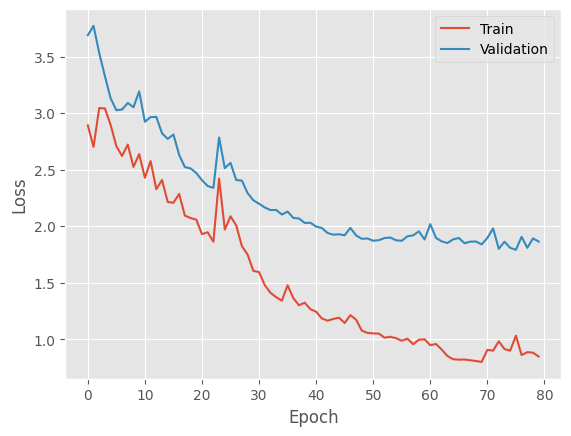

In [10]:
# Training the model
model = GraphLSTM(num_features=5, hidden_channels=64, num_classes=4, num_time_steps=49).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
criterion = torch.nn.MSELoss()  # we use Mean Squared Error loss for regression tasks

# Train and validation losses
train_losses = []
val_losses = []

epochs = 80

for epoch in range(epochs):  
    # Training
    model.train()
    for batch in train_dataloader:
        batch = batch.to(device)  # move batch to the device
        optimizer.zero_grad()  # set gradients to zero
        out = model(batch)  # forward pass

        # Only take the position predictions (first two dimensions of the last dimension) for loss calculation
        pos_out = out[..., :2]
        pos_labels = batch.y[..., :2]

        loss = criterion(pos_out, pos_labels)  # compute loss
        loss.backward()  # backward pass (compute gradients)
        optimizer.step()  # update model parameters
    train_losses.append(loss.item())


    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            out = model(batch)
            pos_out = out[..., :2]
            pos_labels = batch.y[..., :2]
            val_loss += criterion(pos_out, pos_labels).item() * batch.num_graphs
    

    val_loss /= len(val_dataset)  # compute average validation loss
    val_losses.append(val_loss)

    print(f'Epoch: {epoch+1}, Training Loss: {loss.item()}, Val Loss: {val_loss}')
import matplotlib.pyplot as plt
# Plot train and validation losses
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [20]:
# Measure performance of model on test set
model.eval()
test_loss = 0
with torch.no_grad():
    for batch in test_dataloader:
        batch = batch.to(device)
        out = model(batch)
        pos_out = out[..., :2]
        pos_labels = batch.y[..., :2]
        test_loss += criterion(pos_out, pos_labels).item() * batch.num_graphs

test_loss /= len(test_dataset)  # compute average test loss
print(f'Test Loss for task 2: {test_loss}')

Test Loss for task 2: 1.973521685359454


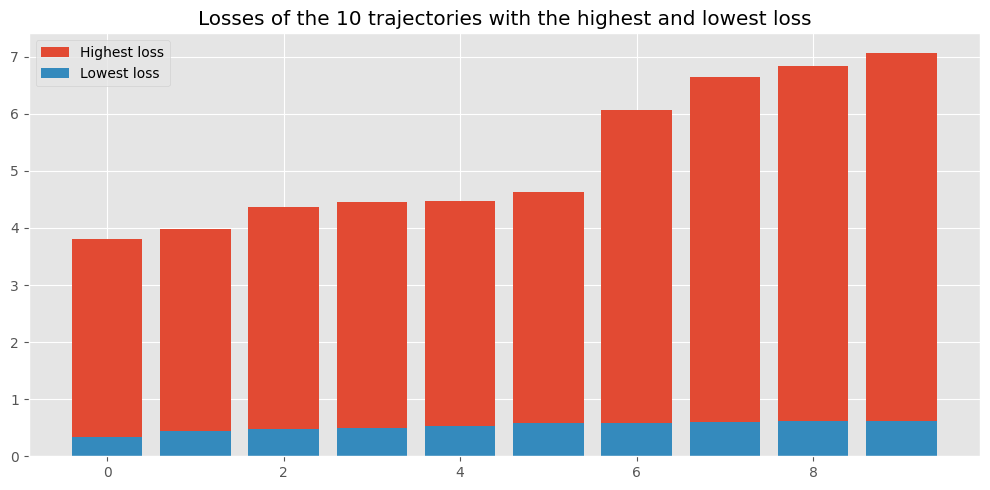

In [18]:
# 10a experiment: grab 10 trajectories from the experiment set that were correctly predicted and 10 that were incorrectly predicted to analyse them

experiment_dataloader = DataLoader(test_dataset, batch_size=1)

experiment_losses = []
experiment_predictions = []
experiment_labels = []

# Validation
model.eval()
with torch.no_grad():
    for batch in experiment_dataloader:
        batch = batch.to(device)
        out = model(batch)
        pos_out = out[..., :2]
        pos_labels = batch.y[..., :2]
        loss = criterion(pos_out, pos_labels).item() * batch.num_graphs
        experiment_losses.append(loss)
        experiment_predictions.append(pos_out)
        experiment_labels.append(pos_labels)



#val_loss /= len(val_dataset)  # compute average validation loss
#val_losses.append(val_loss)


#model.eval()
#with torch.no_grad():
#    for batch in experiment_dataloader:
#        batch = batch.cpu()
#        out = model.cpu()(batch)
#        loss = criterion(out, batch.y)
#        experiment_losses.append(loss.item())
#        experiment_predictions.append(out)
#        experiment_labels.append(batch.y)

# Get the indices of the 10 trajectories with the highest loss
highest_loss_indices = np.argsort(experiment_losses)[-10:]

# Get the indices of the 10 trajectories with the lowest loss
lowest_loss_indices = np.argsort(experiment_losses)[:10]

# np.array(experiment_losses)[highest_loss_indices]
# plot 10 bars with the losses of the 10 trajectories with the highest loss and the 10 trajectories with the lowest loss with the same y-axis
plt.figure(figsize=(10, 5))
plt.bar(np.arange(10), np.array(experiment_losses)[highest_loss_indices], label='Highest loss')
plt.bar(np.arange(10), np.array(experiment_losses)[lowest_loss_indices], label='Lowest loss')
plt.title('Losses of the 10 trajectories with the highest and lowest loss')
plt.tight_layout()
plt.legend()
plt.show()


In [141]:
experiment_predictions[0][0]

tensor([[-5.9816,  3.0521],
        [-6.2978,  3.0182],
        [-6.3833,  3.0958],
        [-6.3452,  3.1622],
        [-6.2881,  3.2149],
        [-6.2301,  3.2701],
        [-6.1727,  3.3295],
        [-6.1126,  3.3873],
        [-6.0472,  3.4390],
        [-5.9754,  3.4831],
        [-5.8977,  3.5203],
        [-5.8154,  3.5526],
        [-5.7301,  3.5822],
        [-5.6435,  3.6113],
        [-5.5568,  3.6413],
        [-5.4712,  3.6732],
        [-5.3873,  3.7073],
        [-5.3053,  3.7437],
        [-5.2251,  3.7819],
        [-5.1467,  3.8214],
        [-5.0699,  3.8615],
        [-4.9944,  3.9019],
        [-4.9200,  3.9421],
        [-4.8466,  3.9819],
        [-4.7741,  4.0213],
        [-4.7023,  4.0600],
        [-4.6312,  4.0982],
        [-4.5608,  4.1358],
        [-4.4911,  4.1729],
        [-4.4219,  4.2095],
        [-4.3534,  4.2456],
        [-4.2855,  4.2811],
        [-4.2183,  4.3161],
        [-4.1517,  4.3505],
        [-4.0858,  4.3841],
        [-4.0207,  4

In [159]:
def plot_trajectories(indices, title=""):
    trajectories = test_dataset[indices]

    # fig, axes = plt.subplots(1, len(trajectories), sharex=True, sharey=True)
    fig, axes = plt.subplots(1, len(trajectories), sharex=True, sharey=True, figsize=(20, 5))

    # set axes limits
    #axes[0].set_xlim(-10, 10)
    #axes[0].set_ylim(-10, 10)

    # iterate over projections
    for i in range(len(trajectories)):
        # Get the initial position
        initial_position_x = trajectories.x[i][1]
        initial_position_y = trajectories.x[i][2]

        #get the sequence of positions
        x_sequence=[]
        y_sequence=[]
        for j in range(49):
            x_sequence.append(trajectories.y[...,:2][i][j][0])
            y_sequence.append(trajectories.y[...,:2][i][j][1])

        # Get the final position
        final_position_x = x_sequence[-1]
        final_position_y = y_sequence[-1]

        axes[i].scatter(initial_position_x, initial_position_y, label='Initial position', marker='o', s=100)
        for j in range(48):
            axes[i].scatter(x_sequence[j], y_sequence[j], marker='.',c="yellow", s=100)
        
        axes[i].scatter(final_position_x, final_position_y, label='Final position', marker='x', s=100)

        #get the predicted sequence of positions
        x_sequence_predicted=[]
        y_sequence_predicted=[]

        for j in range(49):
            x_sequence_predicted.append(experiment_predictions[indices][i][j][0])
            y_sequence_predicted.append(experiment_predictions[indices][i][j][1])

        for j in range(48):
            #Would be nice to keep the label only once for the symbol without new colors           
            #axes[i].scatter(x_sequence_predicted[j], y_sequence_predicted[j], label="Predicted trajectory", marker='.', s=100)
            axes[i].scatter(x_sequence_predicted[j], y_sequence_predicted[j], marker=',', c="green", s=10)

        axes[i].scatter(x_sequence_predicted[-1], y_sequence_predicted[-1], label='Predicted position', c="blue", marker='p', s=100)

        # Draw dashed line from initial position to predicted position
        #axes[i].plot([initial_position_x, predicted_position_x], [initial_position_y, predicted_position_y], 'r--')

        # Get the label
        label = experiment_labels[indices]

        # Draw dashed line from initial position to label
        #axes[i].plot([initial_position_x, label[i][0]], [initial_position_y, label[i][1]], 'b--')

        axes[i].legend()
    
    # set title
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


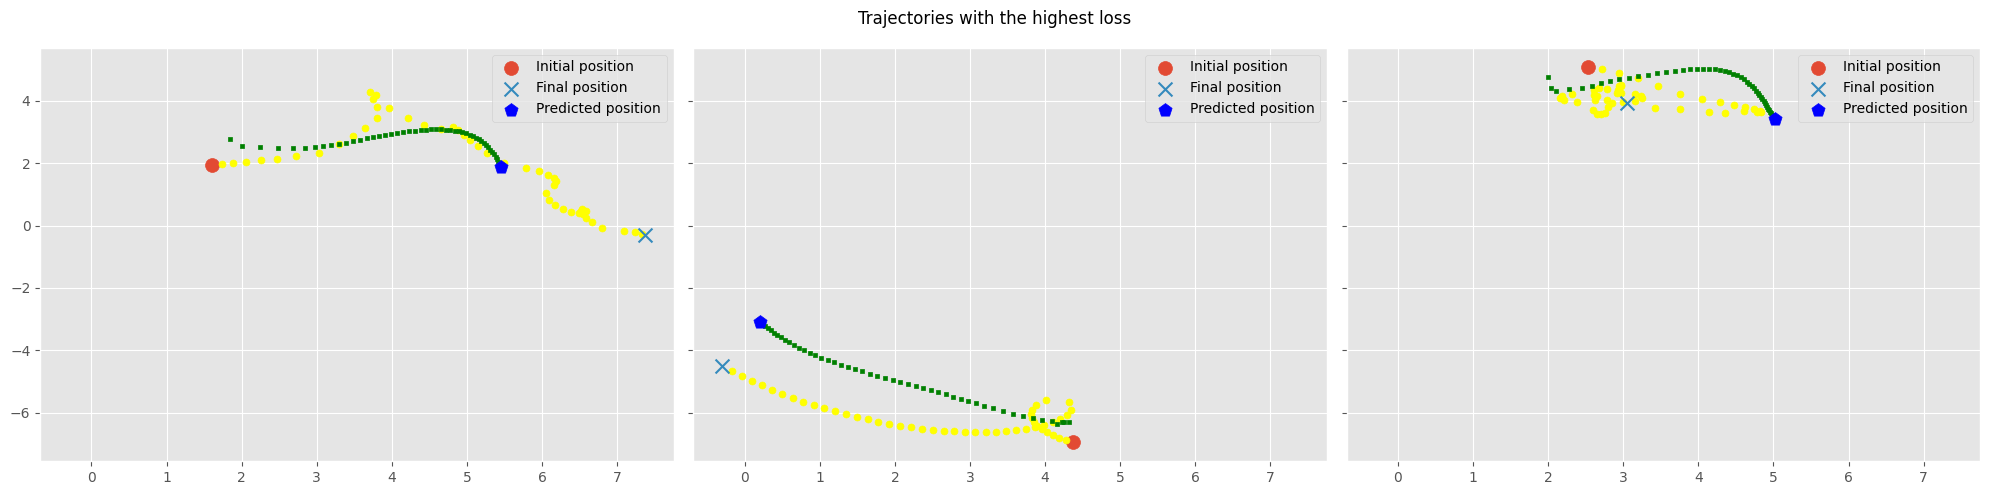

In [160]:
plot_trajectories(highest_loss_indices[0], title="Trajectories with the highest loss")

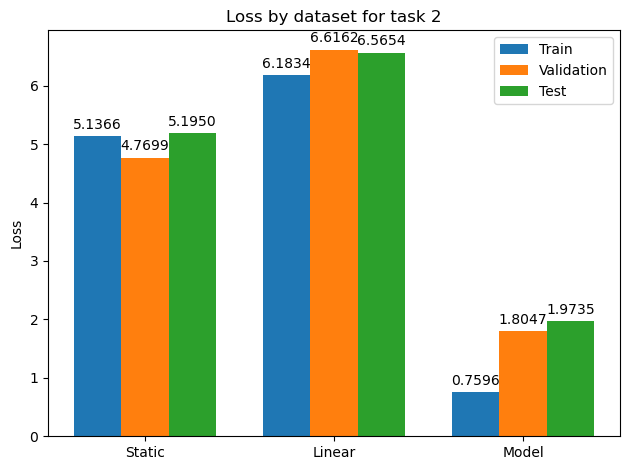

In [21]:

# Plot the losses

import matplotlib.pyplot as plt
import numpy as np

train_losses = [train_loss_static, train_loss_linear, loss.item()]
val_losses = [val_loss_static, val_loss_linear, val_loss]
test_losses = [test_loss_static, test_loss_linear, test_loss]

x = np.arange(len(train_losses))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_losses, width, label='Train')
rects2 = ax.bar(x, val_losses, width, label='Validation')
rects3 = ax.bar(x + width, test_losses, width, label='Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Loss')
ax.set_title('Loss by dataset for task 2')
ax.set_xticks(x)
ax.set_xticklabels(['Static', 'Linear', "Model"])
ax.legend()

# Add numbers on top of bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:  # for each bar
        height = rect.get_height()  # get height of bar
        ax.annotate(f'{height:0.4f}',  # annotate with height
                    xy=(rect.get_x() + rect.get_width() / 2, height),  # put label in the middle of the bar
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Do the autolabel
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

---
# Task 3

In [29]:
import torch
import torch.nn as nn
from torch_geometric.nn import SAGEConv

class Encoder(nn.Module):
    def __init__(self, num_features, hidden_channels, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_channels * 2)
        self.conv2 = SAGEConv(hidden_channels * 2, hidden_channels)
        self.mean = SAGEConv(hidden_channels, latent_dim)
        self.log_var = SAGEConv(hidden_channels, latent_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        
        mean = self.mean(x, edge_index)
        log_var = self.log_var(x, edge_index)
        
        return mean, log_var


class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_channels, output_dim, num_time_steps):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(input_size=latent_dim, hidden_size=hidden_channels*2, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_channels * 2, output_dim)
        )
        self.num_time_steps = num_time_steps

    def forward(self, z):
        z = z.unsqueeze(1).repeat(1, self.num_time_steps, 1)
        z, _ = self.lstm(z)
        return self.fc(z)


class GraphVALSTM(nn.Module):
    def __init__(self, num_features, hidden_channels, latent_dim, output_dim, num_time_steps):
        super(GraphVALSTM, self).__init__()
        self.encoder = Encoder(num_features, hidden_channels, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_channels, output_dim, num_time_steps)

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, data):
        mean, log_var = self.encoder(data)
        z = self.reparameterize(mean, log_var)
        return self.decoder(z), mean, log_var


In [46]:
# Do single forward pass on one batch of train_dataloader

# Initialize the GraphVALSTM model's params
num_features = 5  # Number of input features for each node
hidden_channels = 64  # Number of hidden channels in the network
latent_dim = 8  # Dimension of the latent space
output_dim = 4  # Dimension of the output for each time step (e.g. x, y, vx, vy)
num_time_steps = 49  # Number of time steps in the output trajectories

model = GraphVALSTM(num_features, hidden_channels, latent_dim, output_dim, num_time_steps)

model = model.to(device)

# Take a single graph from the dataloader
single_graph = next(iter(train_dataloader))[0]

# Move the single graph to the appropriate device (optional, if you are using GPU)
single_graph = single_graph.to(device)

# Pass it through the model
output, mean, log_var = model(single_graph)

# Make it a function that takes a single graph and returns the output of the model
def forward_pass(model, graph):
    graph = graph.to(device)
    output, mean, log_var = model(graph)
    return output, mean, log_var

outputs = []
means = []
log_vars = []
# Do 4 forward passes on the same data
for i in range(4):
    single_graph = next(iter(train_dataloader))[0]
    output, mean, log_var = forward_pass(model, single_graph)
    outputs.append(output)
    means.append(mean)
    log_vars.append(log_var)

In [88]:
# Train the model

import torch
import torch.optim as optim
from torch.nn import functional as F

# Initialize the GraphVALSTM model's params
num_features = 5  # Number of input features for each node
hidden_channels = 64  # Number of hidden channels in the network
latent_dim = 16  # Dimension of the latent space
output_dim = 4  # Dimension of the output for each time step (e.g. x, y, vx, vy)
num_time_steps = 49  # Number of time steps in the output trajectories

# Parameters
num_epochs = 20
learning_rate = 0.001

# Initialize the model
model = GraphVALSTM(num_features, hidden_channels, latent_dim, output_dim, num_time_steps).to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
beta = 0.005

# Training Loop
for epoch in range(num_epochs):
    # Training
    model.train()
    train_total_loss = 0
    train_mse_loss = 0
    train_kl_div = 0
    mean_variances = 0

    for batch in train_dataloader:
        # Move batch to device
        batch = batch.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        recon_batch, mean, log_var = model(batch)
        
        # Compute the ELBO loss
        mse_loss = F.mse_loss(recon_batch[:, :, :2], batch.y[:, :, :2])  # Compute MSE loss only on positions
        kld_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())  # Compute KLD loss
        loss = mse_loss + kld_loss * beta
        
        # Accumulate losses
        train_mse_loss += mse_loss.item()
        train_kl_div += kld_loss.item()
        train_total_loss += loss.item()
        
        # Backward pass
        loss.backward()
        
        # Parameter update
        optimizer.step()
        
        mean_variances += torch.exp(log_var).mean().item()
    
    train_total_loss /= len(train_dataloader.dataset)
    train_mse_loss /= len(train_dataloader.dataset)
    train_kl_div /= len(train_dataloader.dataset)
    mean_variances /= len(train_dataloader.dataset)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            # Move batch to device
            batch = batch.to(device)
            
            # Forward pass
            recon_batch, mean, log_var = model(batch)
            
            # Compute the ELBO loss
            mse_loss = F.mse_loss(recon_batch[:, :, :2], batch.y[:, :, :2])
            kld_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
            loss = mse_loss + kld_loss
            
            val_loss += loss.item()
    
    val_loss /= len(val_dataloader.dataset)
    
    # Print losses
    print(f'Epoch: {epoch+1}, Training Total Loss: {train_total_loss:.6f}, Training MSE Loss: {train_mse_loss:.6f}, Training KL Divergence: {train_kl_div:.6f}, Validation Loss: {val_loss:.6f}, Mean of Variances: {mean_variances:.6f}')


Epoch: 1, Training Total Loss: 0.683250, Training MSE Loss: 0.664218, Training KL Divergence: 3.806376, Validation Loss: 1.951993, Mean of Variances: 0.032003
Epoch: 2, Training Total Loss: 0.565314, Training MSE Loss: 0.522275, Training KL Divergence: 8.607952, Validation Loss: 20.177754, Mean of Variances: 0.029136
Epoch: 3, Training Total Loss: 0.368354, Training MSE Loss: 0.261881, Training KL Divergence: 21.294788, Validation Loss: 22.147991, Mean of Variances: 0.024427
Epoch: 4, Training Total Loss: 0.329040, Training MSE Loss: 0.220279, Training KL Divergence: 21.752096, Validation Loss: 22.148330, Mean of Variances: 0.023569
Epoch: 5, Training Total Loss: 0.306839, Training MSE Loss: 0.201070, Training KL Divergence: 21.153649, Validation Loss: 19.584903, Mean of Variances: 0.024325
Epoch: 6, Training Total Loss: 0.298418, Training MSE Loss: 0.195149, Training KL Divergence: 20.653793, Validation Loss: 22.890115, Mean of Variances: 0.024650
Epoch: 7, Training Total Loss: 0.2868

In [96]:
outputs = []
means = []
log_vars = []
input_data = []
# Do 4 forward passes on the same data
single_graph = next(iter(train_dataloader))[0]
for _ in range(4):
    output, mean, log_var = forward_pass(model, single_graph)
    outputs.append(output)
    means.append(mean)
    log_vars.append(log_var)
    # input_data.append(single_graph)

log_vars[0]

tensor([[-7.5839e-02,  4.1293e-02,  6.0762e-02, -6.8808e-04, -1.0592e-01,
         -1.6291e-01, -1.2649e-01, -2.3502e+00, -2.3104e+00, -2.0842e-01,
         -2.0831e-02, -5.3501e-02,  1.0670e-01, -6.6760e-02, -3.6387e-02,
          1.4466e-01],
        [-1.2700e-01, -6.1883e-02,  1.7246e-01,  2.8788e-02, -2.0781e-02,
         -1.0671e-01, -5.0750e-02, -2.6547e+00, -2.6893e+00,  3.8711e-02,
          8.3513e-02,  1.1279e-01,  3.3740e-02,  1.9877e-02, -1.6349e-01,
          3.5023e-02],
        [ 2.4308e-03, -2.0219e-02,  7.5782e-02, -2.0299e-02, -4.7459e-02,
         -1.7560e-01,  1.2618e-01, -2.6321e+00, -2.6988e+00, -2.1526e-02,
          6.7072e-03,  2.4858e-02, -1.1383e-03, -8.6833e-04, -5.8235e-02,
          8.5535e-02],
        [-3.8658e-02, -4.9039e-02,  1.7892e-01, -3.0387e-02,  9.2500e-03,
         -1.7882e-01, -6.3693e-02, -2.7627e+00, -2.3903e+00, -4.8526e-02,
          2.7398e-02, -6.0689e-02,  3.9775e-02, -1.1361e-01, -7.9045e-02,
          3.3165e-02],
        [-3.7473e-02

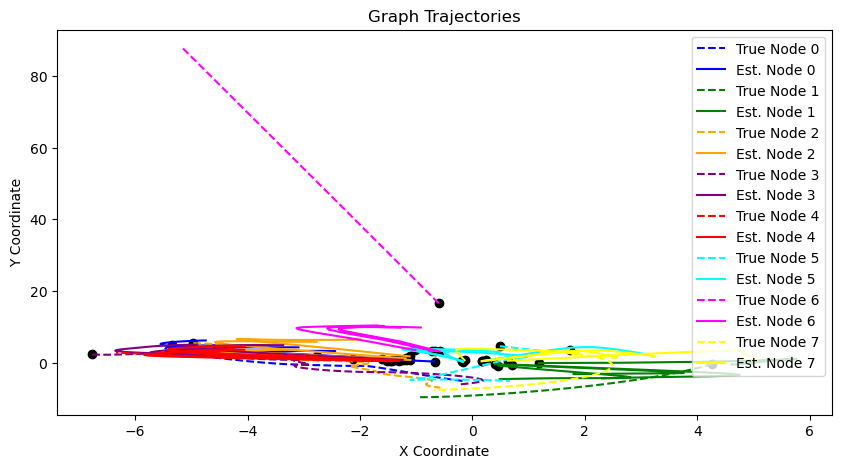

In [97]:
import matplotlib.pyplot as plt

def plot_graph_trajectories(outputs, true_trajectories):
    plt.figure(figsize=(10, 5))
    
    # Colors to differentiate the true and estimated trajectories
    colors = ['blue', 'green', 'orange', 'purple', 'red', "cyan", "magenta", "yellow"]
    
    # Go through all the nodes in the graph
    for node_index in range(outputs[0].shape[0]):
        
        # Plot true trajectory for the current node
        true_x_coords = true_trajectories[node_index, :, 0].cpu().detach().numpy()
        true_y_coords = true_trajectories[node_index, :, 1].cpu().detach().numpy()
        plt.plot(true_x_coords, true_y_coords, label=f'True Node {node_index}', color=colors[node_index % len(colors)], linestyle='dashed')
        plt.scatter(true_x_coords[0], true_y_coords[0], color='black')
        
        # Plot the estimated trajectories for the current node
        for i, output in enumerate(outputs):
            x_coords = output[node_index, :, 0].cpu().detach().numpy()
            y_coords = output[node_index, :, 1].cpu().detach().numpy()
            if i == 0:
                plt.plot(x_coords, y_coords, label=f'Est. Node {node_index}', color=colors[node_index % len(colors)])
            else:
                plt.plot(x_coords, y_coords, color=colors[node_index % len(colors)])
            plt.scatter(x_coords[0], y_coords[0], color='black')
    
    # Add labels and title
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title("Graph Trajectories")
    plt.legend()
    
    # Display the plot
    plt.show()

# Example usage:
# Assuming true_trajectories is a tensor with the true trajectories.
# true_trajectories shape should be similar to outputs, i.e. [8, 49, 4]
plot_graph_trajectories(outputs, single_graph.y)


## Misc

Plots, checking errors, tensors, anything

/var/folders/z4/_gr926652s36cq6g6g4hfcdh0000gn/T/ipykernel_55628/1061363973.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('rainbow', len(y))


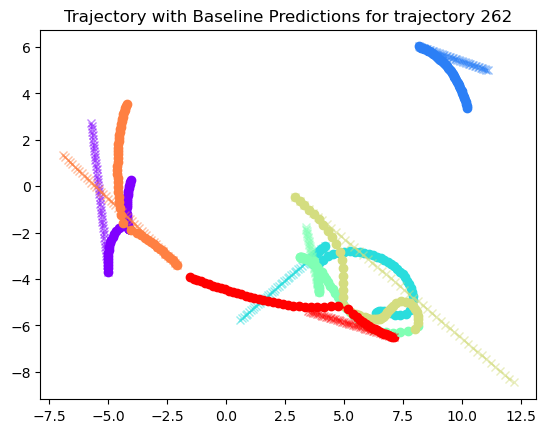

In [220]:

#### Plot a single trajectory for task 2

i = np.random.randint(low=0, high=899) # Index of trajectory
X, y= load_array(f'data/task 2_3/train/trajectory_{i}.npz', task='task 2')
# convert to tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Make predictions
from scipy.spatial.distance import pdist, squareform

# WARNING! This redefines the create_adjacency_matrix function from earlier
def create_adjacency_matrix(X):
    # Calculate Euclidean distance
    distances = pdist(X[:, 1:3], metric='euclidean')

    # Convert pairwise distances into a square matrix.
    adjacency_matrix = squareform(distances)

    # Inverse the distances to get inverse distance adjacency
    adjacency_matrix = 1 / (adjacency_matrix + 1e-5)  # add a small value to avoid division by zero

    # Get edge index from adjacency matrix
    edge_index = torch.tensor(np.where(adjacency_matrix != 0), dtype=torch.long)

    return edge_index

edge_index = create_adjacency_matrix(X.numpy())



import matplotlib.pyplot as plt
# Assuming X, y are the tensors to be plotted
# Assuming edge_index is created

data = Data(x=X, y=y, edge_index=edge_index)
data = data.to(device)  # move data to the device where the model is
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Turn off gradients for prediction
    prediction = model(data)  # Get prediction

import matplotlib.pyplot as plt

def plot_trajectory_with_baseline(X, y, plot_start=True):
    colors = plt.cm.get_cmap('rainbow', len(y))

    for idx, traj in enumerate(y):
        color = colors(idx)

        if plot_start:
            plt.scatter(X[idx, 1], X[idx, 2], color=color, marker='o')  # plot start positions

        plt.plot(traj[:, 0], traj[:, 1], color=color, linestyle='-', marker='o')  # plot real trajectory

        # linear_baseline: initial x,y coordinates plus velocity times time
        preds = np.zeros_like(traj)
        for t in range(len(preds)):
            preds[t, 0:2] = X[idx, 1:3] + X[idx, 3:5] * t/10

        plt.plot(preds[:, 0], preds[:, 1], color=color, linestyle='--', marker='x', alpha=0.5)  # plot baseline predictions
    # set title for plot
    plt.title(f"Trajectory with Baseline Predictions for trajectory {i}")
    plt.show()

plot_trajectory_with_baseline(X.numpy(), y.numpy())

